In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sasmodels.core import load_model
from sasdata.dataloader.loader import Loader
from sasdata.data_util.loader_exceptions import NoKnownLoaderException
from contextlib import suppress
from sasmodels.bumps_model import Model, Experiment
from sasmodels.mixture import *

from bumps.names import FitProblem
from bumps.mapper import MPIMapper
from bumps.fitters import * 

import argparse, glob, os, shutil, pdb, time, datetime, json

In [2]:
# Following are most likely spherical micelles with a PHFBA core and PDEGEEA corona
SLD_CORE = 1.85
SLD_CORONA = 0.817
SLD_SOLVENT_LIST = {'dTHF': 6.349, 'THF': 0.183, 'D2O':6.36, 
'H2O':-0.561, 'dCF': 3.156, 'dTol':5.664, 'dAcetone':5.389,
'dTHF0':6.360, 'dTHF25':6.357, 'dTHF50':6.355, 'dTHF75':6.352,'hTHF':1.0
}
block_params = {'DEG': {'density':1.1, 'MW':188.22},
                'PEG': {'density':1.09, 'MW': 480.0},
                'F': {'density':1.418, 'MW':254.10}
                } 
DOP = {'DEG50F25' : (45, 30), # (EG, F)
       'DEG50F25b': (48, 27), 
       'DEG50F50' : (48, 52),
       'DEG50F75' : (46.25, 78.75),
       'PEG50F25' : (41.25, 33.75),
       'PEG50F50' : (50, 50)
       }
Navg = 6.02e23 
conversion = 1e24
block_vols = {}
for key, value in block_params.items():
    block_vols[key] = conversion*((value['MW']/value['density'])/Navg)

NUM_STEPS = 5

SI_FILE_LOC = './EXPTDATA_V2/sample_info_OMIECS.csv'
DATA_DIR = './EXPTDATA_V2/inco_bg_sub/'

## Loading the data and fitted params

In [13]:
def load_data_from_file(fname, use_trim=False):
    SI = pd.read_csv(SI_FILE_LOC)
    flag = SI["Filename"]==fname
    metadata = SI[flag]
    loader = Loader()
    data = loader.load(DATA_DIR+'%s'%fname)[0]
    
    if not use_trim:
        data.qmin = min(data.x)
        data.qmax = max(data.x)
    else:
        data.qmin = min(data.x)
        data.qmax = data.x[-metadata['Highq_trim']]
        
    return data, metadata

def setup_model(model):
    hardsphere = load_model("hardsphere")
    # read more about it here https://pubs.rsc.org/en/content/articlelanding/2022/cp/d2cp00477a
    # and https://doi.org/10.1063/1.446055
    if model=='sph':
        sas_model = load_model("../models/spherical_micelle.py")
    elif model=='cyl':
        sas_model = load_model("../models/cylindrical_micelle.py")
    elif model=='elp':
        sas_model = load_model("../models/ellipsoidal_micelle.py")

    if model=="cyl":
        bumps_model.B_length_core.range(20.0,1000.0)
    elif model=="elp":
        bumps_model.B_eps.range(1.0,20.0)

    model_info = make_mixture_info([hardsphere.info, sas_model.info], operation="*")
    model = MixtureModel(model_info, [hardsphere, sas_model])
    bumps_model = Model(model=model)

    print(bumps_model.parameters().keys())
    bumps_model.B_radius_core_pd.range(0.0, 0.5)
    bumps_model.B_rg.range(0.0, 200.0)
    bumps_model.B_rg_pd.range(0.0, 0.3)
    bumps_model.B_d_penetration.range(0.75, 1.0)    
    bumps_model.scale.range(1e-15, 1e-5)
    # use default bounds
    bumps_model.B_v_core.fixed = True 
    bumps_model.B_v_corona.fixed = True
    bumps_model.B_n_aggreg.range(1.0, 1000.0)
    # use fixed values
    bumps_model.background.fixed = True 
    bumps_model.background.value = 0.0
    bumps_model.B_sld_core.fixed = True 
    bumps_model.B_sld_core.value = SLD_CORE
    bumps_model.B_sld_corona.fixed = True 
    bumps_model.B_sld_corona.value = SLD_CORONA
    bumps_model.B_sld_solvent.fixed = True 

    # ranges of SQ interactions
    bumps_model.A_radius_effective.range(10,100)
    bumps_model.A_volfraction.range(0.0,1.0) 

    return sas_model, bumps_model

In [14]:
def fit_file_model(fname, model):
    start = time.time()
    data, metadata = load_data_from_file(fname, use_trim=True)
    print('Fitting the following sample : \n', metadata)
    SLD_SOLVENT = SLD_SOLVENT_LIST[metadata.Solvent.values[0]]
    sas_model, bumps_model = setup_model(model)
    dop = DOP[metadata["Matrix"].values[0]]
    V_CORONA = dop[0]*block_vols[metadata["EG_group"].values[0]]
    V_CORE = dop[1]*block_vols["F"] 
    bumps_model.B_v_core.value = V_CORE 
    bumps_model.B_v_corona.value = V_CORONA
    bumps_model.B_sld_solvent.value = SLD_SOLVENT
    print('Using the following model for fitting : \n', sas_model.info.name)
    cutoff = 1e-3  # low precision cutoff
    expt = Experiment(data=data, model=bumps_model, cutoff=cutoff)
    problem = FitProblem(expt)
    # mapper = MPIMapper.start_mapper(problem, None, cpus=0)
    driver = FitDriver(fitclass=DEFit, problem=problem, mapper=None, steps=NUM_STEPS)
    driver.clip() # make sure fit starts within domain
    x0 = problem.getp()
    x, fx = driver.fit()
    problem.setp(x)
    dx = driver.stderr()
    print("final chisq", problem.chisq_str())
    driver.show_err() 
    print('Final fitting parameters for : ', fname)
    print('Parameter Name\tFitted value')
    for key, param in bumps_model.parameters().items():
        if not param.fixed:
            print(key, '\t', '%.2e'%param.value)

    fig, axs = plt.subplots(1,2, figsize=(4*2, 4))
    fig.subplots_adjust(wspace=0.3)
    # axs[0].errorbar(data.x, data.y, yerr=data.dy, fmt='o', 
    # ms=4, label='True', markerfacecolor='none', markeredgecolor='tab:blue')
    axs[0].scatter(data.x, data.y, label='True')
    # plot predicted and data curve
    min_max_mask = (data.x >= data.qmin) & (data.x <= data.qmax)
    q_mask = data.x[min_max_mask]
    axs[0].axvline(x=data.qmin, color='k')
    axs[0].axvline(x=data.qmax, color='k')   
    # masking from sasmodels : sasmodels/direct_model.py#L270
    axs[0].plot(q_mask, problem.fitness.theory(), label='predicted', color='tab:orange')
    # the fitness computes the kernel on set of data.x computed using resolution
    # see sasmodels/direct_model.py#L259
    # more precisely it is set using resolution.Pinhole1D see /sasmodels/direct_model.py#L268
    axs[0].set_xlabel('q')
    axs[0].set_ylabel('I(q)')
    axs[0].legend()
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    # plot residuals
    residuals = problem.fitness.residuals()
    axs[1].scatter(q_mask, residuals)
    axs[1].set_title('Chisq : %.2e'%problem.chisq())
    axs[1].set_xlabel('q')
    axs[1].set_ylabel('residuals')
    axs[1].set_xscale('log')
    plt.tight_layout()

    end = time.time()
    time_str =  str(datetime.timedelta(seconds=end-start)) 
    print('Total fitting time : %s'%(time_str))

    return data, metadata, bumps_model, driver

## Run through all the files

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './EXPTDATA_V2/inco_bg_sub/D50F25b_10dTol.sub'


Fitting the following sample : 
       Goal  Sample               Name     Matrix EG_group  EG_block  \
0  Control     933  DEG50F25b_10_dTol  DEG50F25b      DEG      50.0   

  Florinated Flor_block  GP_conc_tar  GP_conc_act  ... CP_conc_act  Solvent  \
0          F        25b         10.0        12.54  ...         0.0     dTol   

   Tot_conc_tar Tot_conc_act  Highq_trim  lowq_trim            Filename  \
0          10.0        12.54         100         24  D50F25b_10dTol.sub   

   Unnamed: 19 Highq_trim.1  lowq_trim.1  
0          NaN          110           35  

[1 rows x 22 columns]
dict_keys(['scale', 'background', 'A_radius_effective', 'A_volfraction', 'B_v_core', 'B_v_corona', 'B_sld_solvent', 'B_sld_core', 'B_sld_corona', 'B_radius_core', 'B_radius_core_pd', 'B_radius_core_pd_n', 'B_radius_core_pd_nsigma', 'B_rg', 'B_rg_pd', 'B_rg_pd_n', 'B_rg_pd_nsigma', 'B_d_penetration', 'B_n_aggreg', 'up_frac_i', 'up_frac_f', 'up_angle', 'up_phi', 'B_sld_solvent_M0', 'B_sld_solvent_mtheta'

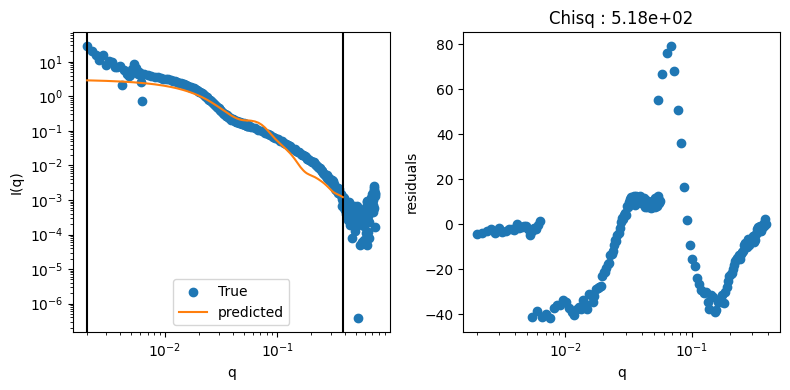

In [15]:
FIT_KEYS = [116,118,129,125,127,132,134,135,136,138,139,140,931,932,933,964,965,970,971]
SI = pd.read_csv(SI_FILE_LOC)
SAVE_DIR = "./"
model = "sph"
for key, values in SI.iterrows():
    if values['Sample'] in FIT_KEYS:
        fname = values['Filename']

    break

savename = SAVE_DIR+'%s.png'%(fname.split('.')[0])
data, metadata, bumps_model, driver = fit_file_model(fname, model)
fitted_params = bumps_model.parameters() 
if model=="sph":
    radius_core = ((fitted_params['B_n_aggreg'] * fitted_params['B_v_core'])/((4/3)*np.pi))**(1/3)
elif model=="cyl":
    radius_core = ((fitted_params["B_n_aggreg"]*fitted_params["B_v_core"])/(np.pi*fitted_params["B_length_core"]))**(1/2)
fitted_params["B_radius_core"] = radius_core.value

for name, param in fitted_params.items():
    if not name=="B_radius_core":
        fitted_params[name] = param.value